<a href="https://colab.research.google.com/github/16shulockm/robotics_556/blob/main/shulock_me556_discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Michael Shulock**,<br>
ME 556 Final Project (December 2024)<br>
**I STRONGLY SUGGEST** to take a look at the plots (particluarly the interactive one) and outputs before re-running any sections. It will take over an hour to run.

# Setup Libraries and Neural Network
The below section of code imports the requested libraries and then sets up the neural network. The dynamics of the system are captured in the NN and the NN predicts the next state of the system. It uses three fully connected layers with 1024 neurons and the first two layers have ReLU activation for nonlinearity. The NN is also trained in this section. The PyTorch class and tensors are formatted in this section. Please select **quad_data.csv** to train the NN.

In [4]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits import mplot3d

# =========================
# Neural Network Definition
# =========================
state_dim = 6  # x, y, z, roll, pitch, yaw
action_dim = 4  # u1, u2, u3, u4 (thrust and torques respectively)
time_dim = 1    # Including time as an input (tried with and without)

class DynamicsNN(nn.Module):
    def __init__(self, state_dim, action_dim, time_dim):
        super(DynamicsNN, self).__init__()
        input_dim = state_dim + action_dim + time_dim
        self.fc1 = nn.Linear(input_dim, 1024) #number of neurons selected based on trial and error
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1024)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(1024, state_dim)

    def forward(self, xut):
        out = self.fc1(xut)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out  # Predicts x_next

# Below is a NN that has dropouts in it, when I suspected overfitting. It made things worse.
'''
# =========================
# Neural Network Definition w/ Dropoutss
# =========================
state_dim = 6  # x, y, z, roll, pitch, yaw
action_dim = 4  # u1, u2, u3, u4
time_dim = 1    # Including time as an input

class DynamicsNN(nn.Module):
    def __init__(self, state_dim, action_dim, time_dim, dropout_p=0.2):
        super(DynamicsNN, self).__init__()
        input_dim = state_dim + action_dim + time_dim
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)  # Added Dropout
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_p)  # Added Dropout
        self.fc3 = nn.Linear(512, state_dim)

    def forward(self, xut):
        out = self.fc1(xut)
        out = self.relu1(out)
        out = self.dropout1(out)  # Apply Dropout
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)  # Apply Dropout
        out = self.fc3(out)
        return out  # Predicts x_next
'''
model = DynamicsNN(state_dim, action_dim, time_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Added weight_decay for L2. Did not help
loss_fn = nn.MSELoss() #Mean squared error loss func.

# ========================================
# Upload and Prepare Training Data (quad_data)
# ========================================
from google.colab import files
!rm -rf '/content/quad_data.csv'
uploaded = files.upload()
data = pd.read_csv(io.StringIO(uploaded['quad_data.csv'].decode('utf-8')))

#Break out data
time_column = 'time'
state_columns = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']
action_columns = ['u1', 'u2', 'u3', 'u4']

t_data = data[time_column].values
x_data = data[state_columns].values
u_data = data[action_columns].values

# Prepare data for supervised learning (predicts next state)
x_current = x_data[:-1]
u_current = u_data[:-1]
t_current = t_data[:-1]
x_next = x_data[1:]
# pytorch syntax
x_current_tensor = torch.tensor(x_current, dtype=torch.float32)
u_current_tensor = torch.tensor(u_current, dtype=torch.float32)
t_current_tensor = torch.tensor(t_current, dtype=torch.float32).unsqueeze(1)
x_next_tensor = torch.tensor(x_next, dtype=torch.float32)

from torch.utils.data import TensorDataset, DataLoader
inputs = torch.cat((x_current_tensor, u_current_tensor, t_current_tensor), dim=1)
dataset = TensorDataset(inputs, x_next_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# =========================
# Train the Neural Network
# =========================
num_epochs = 50 #seems to be a standard number to start. Tried other amounts.
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs_batch, x_next_batch in dataloader:
        optimizer.zero_grad()
        x_pred = model(inputs_batch)
        loss = loss_fn(x_pred, x_next_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs_batch.size(0)
    epoch_loss = running_loss / len(dataset)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}') #prints every 10, 6 dec places.
print("Done with Training.")

Saving quad_data.csv to quad_data.csv
Epoch 1/50, Loss: 1.268348
Epoch 10/50, Loss: 0.001340
Epoch 20/50, Loss: 0.000283
Epoch 30/50, Loss: 0.000182
Epoch 40/50, Loss: 0.000135
Epoch 50/50, Loss: 0.000655
Done with Training.


# Establishing Initial Trajectory
This section pulls data for the initial trajectory that the LQR loop begins with. It also establishes the stepping function for the model so that it can be used when I test the NN in a subsequent section

In [5]:
# ===============================
# Discrete-Time Model Step
# ===============================
def model_step(x, u, t, model):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    u_tensor = torch.tensor(u, dtype=torch.float32)
    t_tensor = torch.tensor([t], dtype=torch.float32)
    with torch.no_grad():
        x_next_tensor = model(torch.cat((x_tensor, u_tensor, t_tensor)).unsqueeze(0))
    return x_next_tensor.numpy().flatten() #Predicts next state of system given state and control values.

# ===========================================
# Upload and Prepare Initial Trajectory Data
# ===========================================
!rm -rf '/content/initial_trajectory.csv'
uploaded = files.upload()
trajectory_data = pd.read_csv(io.StringIO(uploaded['initial_trajectory.csv'].decode('utf-8')))

t_traj = trajectory_data[time_column].values
x_traj = trajectory_data[state_columns].values.T  # shape: (state_dim, N)
u_traj = trajectory_data[action_columns].values

x0 = x_traj[:, 0]
N = len(t_traj)
DT = t_traj[1] - t_traj[0]
t_forw = t_traj #forward time array similar to hw3.

ui = [u_traj[i] for i in range(N)] #Initial conrol inputs from initial trajectory data

Saving initial_trajectory.csv to initial_trajectory.csv


# Testing NN
Several parameters are initialized in this section, but the main purpose is to test the fit of the NN. The initial trajectory's control inputs are fed to the NN and the output trajectory is compared to that of the actual initial trajectory states. This is done using a plot as well as the MSE between the two trajectories.

MSE between NN predicted states and initial trajectory: 0.013924337454143969


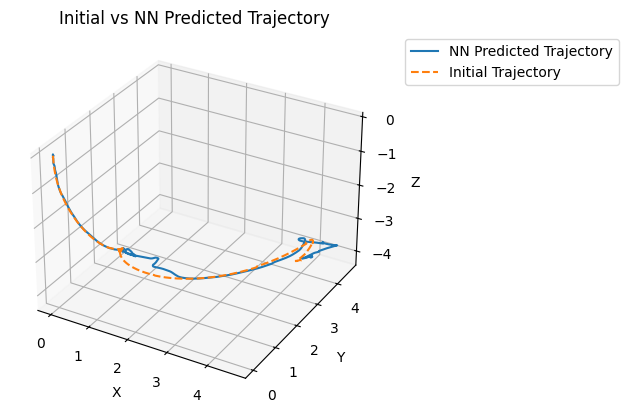

In [10]:
# ===========================================
# Test the Neural Network
# ===========================================

# Extract time, state, and control inputs from the initial trajectory
t_traj = trajectory_data[time_column].values
x_traj = trajectory_data[state_columns].values.T  #(state_dim, N)
u_traj = trajectory_data[action_columns].values   #(N, action_dim)

# Initial location and orientation from the initial trajectory
x0 = x_traj[:, 0]

# Number of time steps (from time vector in data)
N = len(t_traj)
DT = t_traj[1] - t_traj[0]
t_forw = t_traj

# Convert u_traj to a list of control inputs for model_step
ulist = [u_traj[i] for i in range(N)]

# Simulate using the neural network and initial trajectory's control inputs
xn_test = np.zeros((state_dim, N))
xn_test[:, 0] = x0

for i in range(N - 1):
    t = t_traj[i] #steps through time column in initial trajectory csv data
    x_current = xn_test[:, i]
    x_next = model_step(x_current, ulist[i], t, model) #new state values
    xn_test[:, i + 1] = x_next

# Compute MSE between the NN-predicted states (xn_test) and the original trajectory (x_traj)
error = x_traj - xn_test
mse = np.mean(error**2) #Helps give a quick snapshot of how well NN works

print("MSE between NN predicted states and initial trajectory:", mse)

# Plot the trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# NN predicted trajectory
ax.plot(xn_test[0, :], xn_test[1, :], xn_test[2, :], label='NN Predicted Trajectory')
# Original trajectory
ax.plot(x_traj[0, :], x_traj[1, :], x_traj[2, :], label='Initial Trajectory',linestyle='--')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Initial vs NN Predicted Trajectory')
plt.show()

# LQR Section
This section houses the functions required for the LQR loop, as well as the loop itself. The comments outline the logic behind the code, and summarize the process more efficiently than using text here. Much of this is modeled after HW3 but using a discrete time framework.

Iteration 0
Line search max iterations reached.
Cost: 19586.926702, Norm: 1.867234
Iteration 1
Cost: 19166.939044, Norm: 1.934027
Iteration 2
Cost: 18814.922170, Norm: 1.893392
Iteration 3
Cost: 18495.400471, Norm: 1.854932
Iteration 4
Cost: 18206.402067, Norm: 1.816116
Iteration 5
Cost: 17939.549231, Norm: 1.778209
Iteration 6
Cost: 17700.073916, Norm: 1.740306
Iteration 7
Cost: 17420.198753, Norm: 1.705206
Iteration 8
Cost: 17227.236754, Norm: 1.673744
Iteration 9
Cost: 17196.474094, Norm: 1.640350
Iteration 10
Cost: 17010.562789, Norm: 1.605127
Iteration 11
Cost: 16890.398597, Norm: 1.573109
Iteration 12
Cost: 16699.490841, Norm: 1.540181
Iteration 13
Cost: 16557.294970, Norm: 1.507768
Iteration 14
Cost: 16446.910722, Norm: 1.477720
Iteration 15
Cost: 16337.695980, Norm: 1.447488
Iteration 16
Cost: 16291.528563, Norm: 1.417135
Iteration 17
Cost: 16175.737758, Norm: 1.388831
Iteration 18
Cost: 16106.143592, Norm: 1.362221
Iteration 19
Cost: 16079.882029, Norm: 1.336352
Iteration 20
C

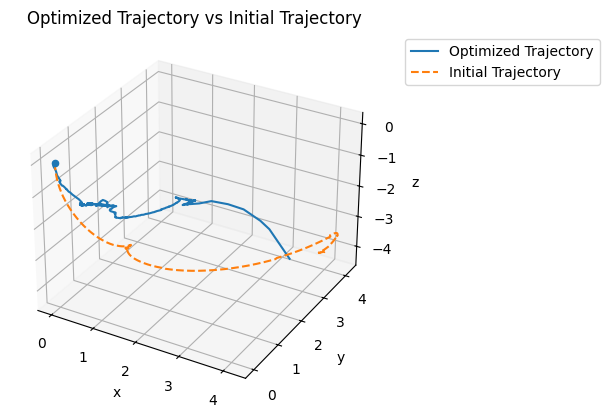

In [17]:
# Warning: This will take a long time to run. It can be stopped early and the next cell will create a plot anyway.
# ===============================
# Compute Jacobians (Discrete)
# ===============================
# Function to get A and B
# Uses PyTorch library to extract the Jacobians, still treating the system dynamics as a "black box"
def compute_jacobians(model, x, u, t):
    x_ = torch.tensor(x, requires_grad=True, dtype=torch.float32)
    u_ = torch.tensor(u, requires_grad=True, dtype=torch.float32)
    t_ = torch.tensor([t], requires_grad=True, dtype=torch.float32)
    xut = torch.cat((x_, u_, t_))
    # From NN
    def model_output(xut):
        x_next = model(xut.unsqueeze(0))
        return x_next.squeeze(0)

    jac = torch.autograd.functional.jacobian(model_output, xut)
    A = jac[:, :state_dim].detach().numpy()    # df/dx
    B = jac[:, state_dim:state_dim+action_dim].detach().numpy()  # df/du
    return A, B

# ===============================
# Cost Matrices and Desired State
# ===============================
# Places most weight on final position, minimizing extra motion. Not as much emphasis on rotations.
Q4 = np.diag([50., 50., 100., 10., 10., 10.])
R4 = np.diag([0.1, 0.1, 0.1, 0.1])
invR4 = np.linalg.inv(R4) #Computes outside of loop/functions to save time.
P14 = np.diag([5000., 5000., 10000., 1., 1., 1.]) # large value or else NN does not push towards target location

xd_T = x_traj[:, -1] # Desired State

def xd(k):
    return xd_T #Not really needed, artifact from how I had this coded before I made several changes

# Running Cost
def l(k, xl, ul):
    x = xl[:, k]
    u = ul[k]
    return x @ Q4 @ x.T + u @ R4 @ u.T

#Total Cost
def J(xl, ul):
    J_val = 0
    # Summation over discrete steps with 0.5*DT scaling
    for k in range(N):
        J_val += 0.5 * l(k, xl, ul)*DT
    # Terminal cost
    J_val += 0.5 * (xd_T - xl[:, -1]) @ P14 @ (xd_T - xl[:, -1]).T
    return J_val

# Function to simulate quadcopter
def simulate_trajectory(x0, u_list, model):
    x_sim = np.zeros((state_dim, N))
    x_sim[:, 0] = x0 #initialize
    for k in range(N-1):
        x_sim[:, k+1] = model_step(x_sim[:, k], u_list[k], t_forw[k], model)
    return x_sim

xn = np.copy(x_traj) #initialize states
un = ui[:] #Initialize inputs

# Gradients of cost w.r.t x and u:
def afunc(k, xl, ul):
    x = xl[:, k]
    return (Q4 @ x)*DT

def bfunc(k, xl, ul):
    u = ul[k]
    return (R4 @ u)*DT

# ===============================
# Discrete-Time iLQR Backward Pass
# ===============================
def backward_pass(xn, un):
    # Iterating P and r. This approach was to save computation time.
    # Tried to "convert" LQR approach in HW3 to this discrete approach.
    P_list = [None]*N
    r_list = [None]*N
    P_list[-1] = P14
    r_list[-1] = P14 @ (xn[:, -1] - xd_T)

    for k in range(N-2, -1, -1):
        A, B = compute_jacobians(model, xn[:, k], un[k], t_forw[k])
        a = afunc(k, xn, un)
        b = bfunc(k, xn, un)
        #To clean up expressions
        G = R4 + B.T @ P_list[k+1] @ B
        G_inv = np.linalg.inv(G)
        W = B.T @ P_list[k+1] @ A

        P_k = Q4 + A.T @ P_list[k+1] @ A - W.T @ G_inv @ W
        r_k = a + A.T @ r_list[k+1] - W.T @ G_inv @ (b + B.T @ r_list[k+1])

        P_list[k] = P_k
        r_list[k] = r_k
    return P_list, r_list

def DJz(zl, vl, xl, ul):
    intsum = 0
    for k in range(N - 1):
        intsum += afunc(k, xl, ul) @ zl[k] + bfunc(k, xl, ul) @ vl[k]
    terminal_cost = (xd_T - xl[:, -1]).T @ P14 @ zl[-1]
    return intsum + terminal_cost

#functions to get Q R norm (taken from my HW3)
def lnorm(t,xl,ul):
  x = xl[round(t/DT)]
  u = ul[round(t/DT)]
  return x @ Q4 @ x.T + u @ R4 @ u.T

def Jnorm(xl,ul):
  J4 = 0
  for i in t_forw[:-1]:
    J4 = J4 + lnorm(i, xl, ul) * DT
  J4 = .5 * J4
  return J4

def forward_rollout(x0, un_new, model):
    max_u=20.
    un_clipped = [np.clip(u, -max_u, max_u) for u in un_new] #clip inputs to smooth NN outputs.
    return simulate_trajectory(x0, un_clipped, model)
    #return simulate_trajectory(x0, un_new, model) #old non clipped

# ===============================
# iLQR Iteration Loop (Discrete)
# ===============================
# Initializations
norm = np.inf
n = 0
max_iterations = 200
while norm > 0.1 and n < max_iterations:
    print(f'Iteration {n}')
    # compute P and r via backward pass
    P_list, r_list = backward_pass(xn, un)
    # Again trying to compute zeta and v using this "discrete" method. Intialize gain and offset
    gainl = []
    offsetl = []
    for k in range(N):
        A, B = compute_jacobians(model, xn[:, k], un[k], t_forw[k]) #Jacobians
        P = P_list[k]
        r = r_list[k]
        G = R4 + B.T @ P @ B
        G_inv = np.linalg.inv(G)
        K = -G_inv @ (B.T @ P @ A)
        kff = -G_inv @ (bfunc(k, xn, un) + B.T @ r)
        gainl.append(K)
        offsetl.append(kff)

    zlist = [np.zeros(state_dim)]
    for k in range(N-1):
        A, B = compute_jacobians(model, xn[:, k], un[k], t_forw[k])
        z_next = A @ zlist[k] + B @ (gainl[k] @ zlist[k] + offsetl[k])
        zlist.append(z_next)

    vsol = []
    for k in range(N - 1):
        vsol.append(gainl[k] @ zlist[k] + offsetl[k])

    oldcost = J(xn, un)
    djz = DJz(zlist, vsol, xn, un)

    # Armejo Line Search
    # Very similar to HW3
    alpha = 0.1
    beta = 0.5
    gamma = 1.0
    max_line_search_iterations = 15
    newcost = np.inf
    k_search = 0
    while newcost > oldcost + alpha * gamma * djz:
        un_new = []
        for i in range(N - 1):
            un_new.append(un[i] + gamma * vsol[i])
        un_new.append(un[-1])
        xnew = forward_rollout(x0, un_new, model)
        newcost = J(xnew, un_new)
        gamma *= beta
        k_search += 1
        if k_search >= max_line_search_iterations:
            print("Line search max iterations reached.")
            break

    xn = xnew
    un = un_new
    #norm = np.linalg.norm(djz)
    norm = Jnorm(zlist, vsol)
    print(f"Cost: {newcost:.6f}, Norm: {norm:.6f}")
    n += 1

#Replaced with interactive plot to better analyze. See next cell (added after this code ran)
'''
# ===============================
# Plot the Optimized Trajectory
# ===============================
print(x_traj[:,-1])
print(xn[:,-1])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(xn[0], xn[1], xn[2], label='Optimized Trajectory')
ax.plot3D(x_traj[0], x_traj[1], x_traj[2], label='Initial Trajectory', linestyle='--')
ax.scatter(x0[0], x0[1], x0[2])
ax.set_title('Optimized Trajectory vs Initial Trajectory')
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
'''

# Do Not Run Section
This section will export the final state array. I did this so that if you stop the function prematurely, I can still provide you the data for the final state.

In [25]:
'''
#!rm -rf '/content/final_path.csv'
np.savetxt("final_path.csv", xn, delimiter=",")
from google.colab import files
files.download("final_path.csv")
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Primary Plotting Section
This plot uses a tool that is new to me (plotly). It creates an interactive plot of the 3D trajectories (initial and optimized).

In [18]:
import plotly.graph_objs as go

# Convert data for Plotly
# Optimized
x_opt = xn[0]
y_opt = xn[1]
z_opt = xn[2]
# Initial
x_init = x_traj[0]
y_init = x_traj[1]
z_init = x_traj[2]
# Initial Condition for both trajectories
x_start = x0[0]
y_start = x0[1]
z_start = x0[2]

# Create a 3D scatter line plot for the optimized trajectory
opt_trajectory = go.Scatter3d(
    x=x_opt,
    y=y_opt,
    z=z_opt,
    mode='lines',
    name='Optimized Trajectory'
)

# Create a 3D scatter line plot for the initial trajectory
init_trajectory = go.Scatter3d(
    x=x_init,
    y=y_init,
    z=z_init,
    mode='lines',
    name='Initial Trajectory',
    line=dict(dash='dash')
)

# Create a scatter point for the starting position
start_point = go.Scatter3d(
    x=[x_start],
    y=[y_start],
    z=[z_start],
    mode='markers',
    name='Start Point'
)

# Combine all traces into a single figure
fig = go.Figure(data=[opt_trajectory, init_trajectory, start_point])

# Update layout for better readability
fig.update_layout(
    title='Optimized Trajectory vs Initial Trajectory',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    ),
    legend=dict(x=1.05, y=1)
)

# Display interactive 3D plot
fig.show()


# Secondary Plots
This section creates the rest of the plots for the write up (not including those produced in MATLAB)

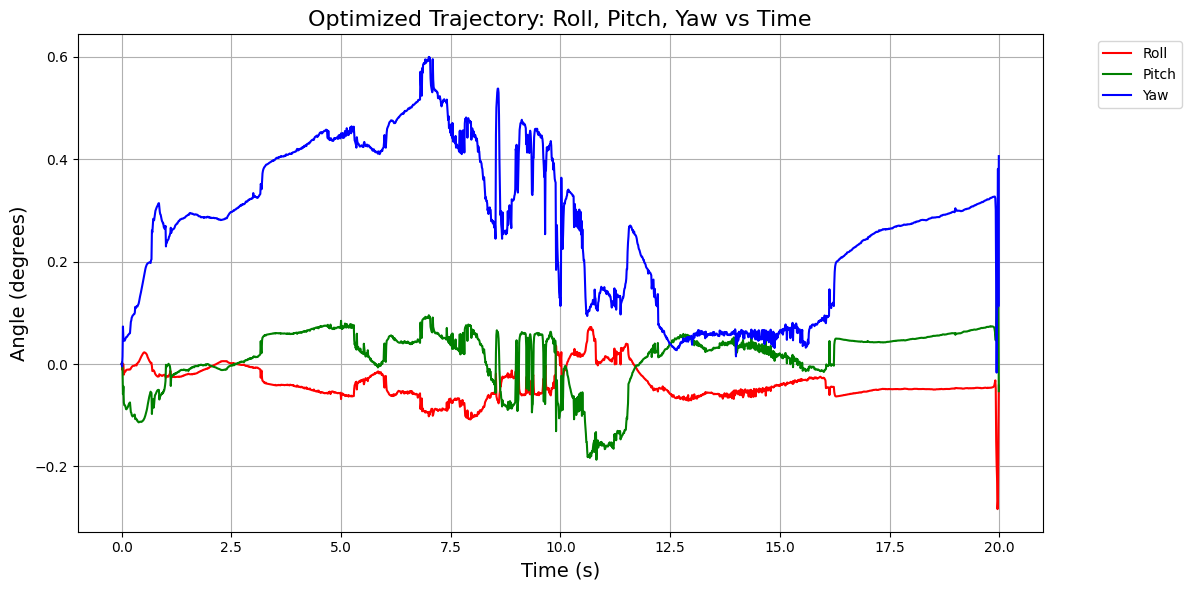

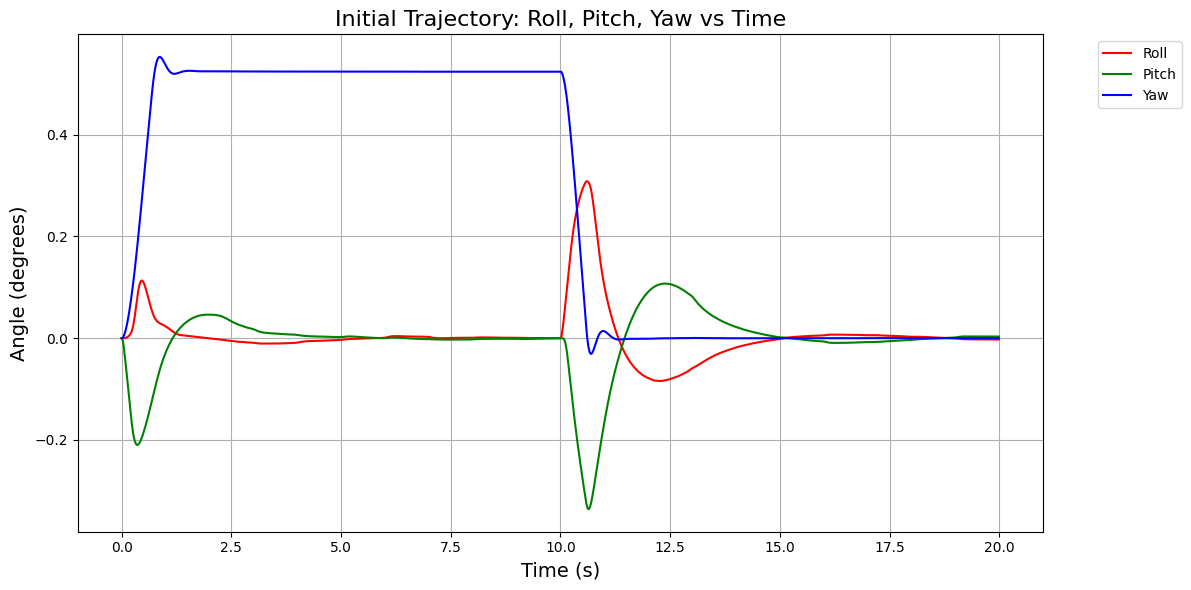

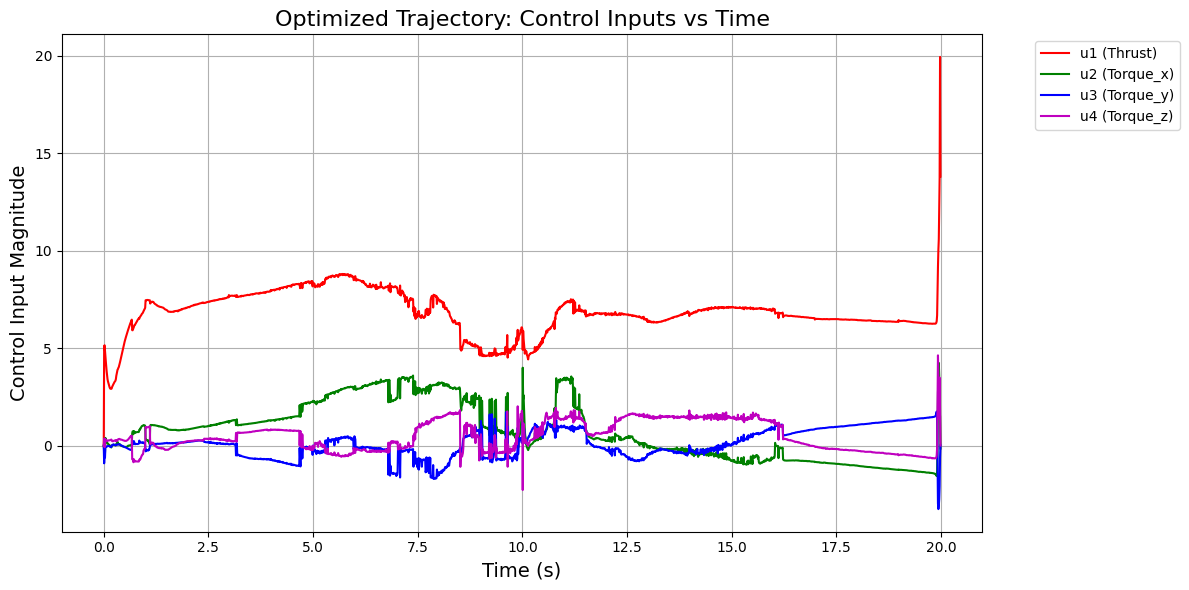

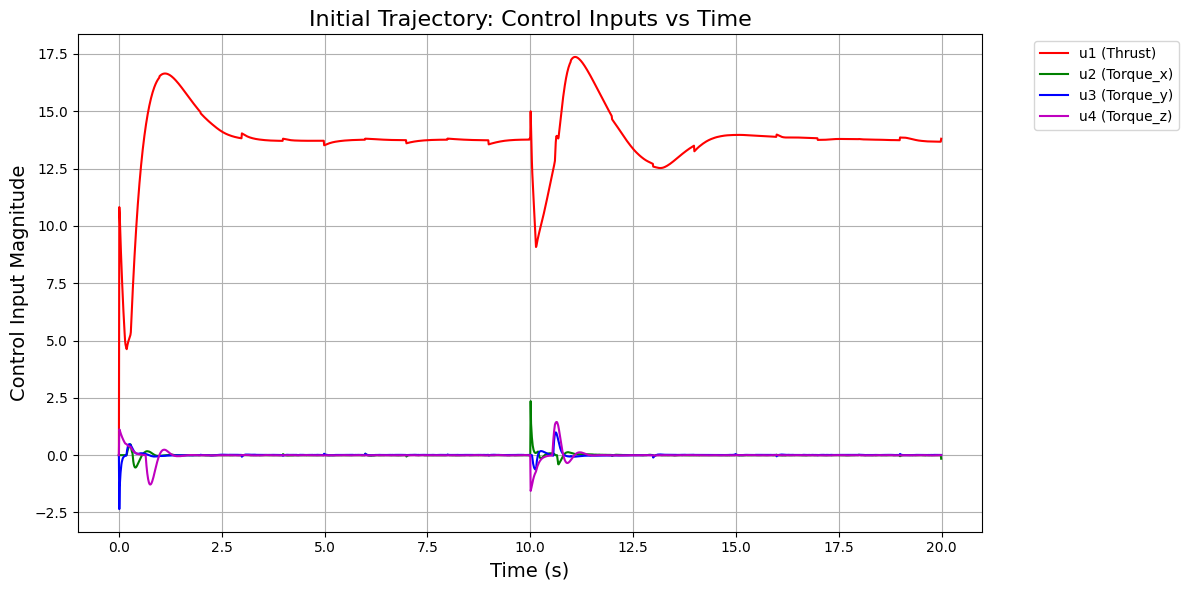

In [29]:
# =======================================
# Plot Roll, Pitch, Yaw for Optimized Trajectory
# =======================================

plt.figure(figsize=(12, 6))

# Plot Roll
plt.plot(t_forw, xn[3, :], label='Roll', color='r')

# Plot Pitch
plt.plot(t_forw, xn[4, :], label='Pitch', color='g')

# Plot Yaw
plt.plot(t_forw, xn[5, :], label='Yaw', color='b')

plt.title('Optimized Trajectory: Roll, Pitch, Yaw vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Angle (degrees)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

# =======================================
# Plot Roll, Pitch, Yaw for Original Trajectory
# =======================================

plt.figure(figsize=(12, 6))

# Plot Roll
plt.plot(t_forw, x_traj[3, :], label='Roll', color='r')

# Plot Pitch
plt.plot(t_forw, x_traj[4, :], label='Pitch', color='g')

# Plot Yaw
plt.plot(t_forw, x_traj[5, :], label='Yaw', color='b')

plt.title('Initial Trajectory: Roll, Pitch, Yaw vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Angle (degrees)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


# =======================================
# Plot Control Inputs for Optimized Trajectory
# =======================================

plt.figure(figsize=(12, 6))

# Plot u1
plt.plot(t_forw, [un[i][0] for i in range(N)], label='u1 (Thrust)', color='r')

# Plot u2
plt.plot(t_forw, [un[i][1] for i in range(N)], label='u2 (Torque_x)', color='g')

# Plot u3
plt.plot(t_forw, [un[i][2] for i in range(N)], label='u3 (Torque_y)', color='b')

# Plot u4
plt.plot(t_forw, [un[i][3] for i in range(N)], label='u4 (Torque_z)', color='m')

plt.title('Optimized Trajectory: Control Inputs vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Control Input Magnitude', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# =======================================
# Plot Control Inputs for Initial Trajectory
# =======================================

plt.figure(figsize=(12, 6))

# Plot u1
plt.plot(t_forw, [ui[i][0] for i in range(N)], label='u1 (Thrust)', color='r')

# Plot u2
plt.plot(t_forw, [ui[i][1] for i in range(N)], label='u2 (Torque_x)', color='g')

# Plot u3
plt.plot(t_forw, [ui[i][2] for i in range(N)], label='u3 (Torque_y)', color='b')

# Plot u4
plt.plot(t_forw, [ui[i][3] for i in range(N)], label='u4 (Torque_z)', color='m')

plt.title('Initial Trajectory: Control Inputs vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Control Input Magnitude', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()